# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'autoencoder'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_fc_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume           temp   rain_1h   snow_1h     clouds_all
count   341736.000000  341736.000000  341736.0  341736.0  341736.000000
mean      3219.063117     282.606462       0.0       0.0      33.918291
std       1903.659315      12.232782       0.0       0.0      38.167380
min          0.000000     245.411835       0.0       0.0       0.000000
25%       1305.094727     273.442223       0.0       0.0       0.000000
50%       3642.661865     284.551956       0.0       0.0       9.848331
75%       4834.411865     292.582085       0.0       0.0      78.658363
max       7454.748047     308.811157       0.0       0.0     111.866798


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  28511.000000
mean       3313.74238    282.688768      0.061611      0.000250     42.122795
std        1971.53206     12.367361      0.678185      0.008298     39.316195
min         

In [6]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341736.000000,341736.000000,341736.0,341736.0,341736.000000
mean,3219.063117,282.606462,0.0,0.0,33.918291
std,1903.659315,12.232782,0.0,0.0,38.167380
min,0.000000,245.411835,0.0,0.0,0.000000
25%,1305.094727,273.442223,0.0,0.0,0.000000
50%,3642.661865,284.551956,0.0,0.0,9.848331
75%,4834.411865,292.582085,0.0,0.0,78.658363
max,7454.748047,308.811157,0.0,0.0,111.866798


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.20857101559638977
Training Loss: 0.15598075967282057
Training Loss: 0.11382955461740493
Validation Loss: 0.0819474132626914
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0776569041237235
Training Loss: 0.06664271639660001
Training Loss: 0.06025627402588725
Validation Loss: 0.05666237927219841
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058230754882097245
Training Loss: 0.054966985732316974
Training Loss: 0.052343262499198316
Validation Loss: 0.05029334006517121
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.050586927281692624
Training Loss: 0.04700918290764093
Training Loss: 0.044109709123149515
Validation Loss: 0.041830749282341324
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04160982482135296
Training Loss: 0.038054075753316284
Training

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:23<30:34, 203.83s/it]

Epoch: 1
Training Loss: 0.1000279444642365
Training Loss: 0.07914879620075226
Training Loss: 0.06824333894997835
Validation Loss: 0.0628563327652015
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06522548612207174
Training Loss: 0.06126868177205324
Training Loss: 0.05866397969424725
Validation Loss: 0.05517202381337626
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05752590480260551
Training Loss: 0.053673045551404355
Training Loss: 0.050828995909541846
Validation Loss: 0.04693962359445149
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04906174307689071
Training Loss: 0.045326240258291364
Training Loss: 0.04224170356988907
Validation Loss: 0.038259875238611456
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.040054334457963706
Training Loss: 0.0367487629968673
Training Lo

 20%|██        | 2/10 [06:51<27:27, 205.88s/it]

Training Loss: 0.005828145701671019
Validation Loss: 0.0030671334099495427
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5227144668996334
Training Loss: 0.41549488648772237
Training Loss: 0.30763299025595187
Validation Loss: 0.1868385657500685
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.16888302836567162
Training Loss: 0.1194170505180955
Training Loss: 0.08724013781175018
Validation Loss: 0.061075514496377346
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06672518895938992
Training Loss: 0.0616368262283504
Training Loss: 0.05828786546364426
Validation Loss: 0.051635778142829956
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05726509465835988
Training Loss: 0.05470271846279502
Training Loss: 0.05246738519519568
Validation Loss: 0.04674589066776667
Validation Accuracy

 30%|███       | 3/10 [10:19<24:09, 207.00s/it]

Epoch: 1
Training Loss: 0.22138931907713413
Training Loss: 0.15455638222396373
Training Loss: 0.09525009820237756
Validation Loss: 0.06594123657834663
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06320302223786711
Training Loss: 0.05827414521947503
Training Loss: 0.055540044140070674
Validation Loss: 0.05358241887742214
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.054442141465842725
Training Loss: 0.050921204509213565
Training Loss: 0.04798758958466351
Validation Loss: 0.0452972621437204
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0457757620792836
Training Loss: 0.042192832259461285
Training Loss: 0.03898109920322895
Validation Loss: 0.03597344328345877
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03616406631655991
Training Loss: 0.033073929324746135
Training L

 40%|████      | 4/10 [13:49<20:48, 208.16s/it]

Training Loss: 0.005771418311633169
Validation Loss: 0.0029878162437516234
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4605178634822369
Training Loss: 0.3943371652066708
Training Loss: 0.32834248095750806
Validation Loss: 0.26030811734413833
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.23220777340233326
Training Loss: 0.17762617476284503
Training Loss: 0.12649003010243176
Validation Loss: 0.08713843280010009
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08341255748644472
Training Loss: 0.07160147033631802
Training Loss: 0.0653556034527719
Validation Loss: 0.06085791727632619
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06403439108282327
Training Loss: 0.060966449044644835
Training Loss: 0.05882676361128688
Validation Loss: 0.05589325654875027
Validation Accuracy

 50%|█████     | 5/10 [17:17<17:20, 208.00s/it]

Training Loss: 0.005533101368346251
Validation Loss: 0.0028509034433799765
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0900265771150589
Training Loss: 0.07068940911442041
Training Loss: 0.06307184787467122
Validation Loss: 0.05699320045414935
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05998250411823392
Training Loss: 0.05511471129953861
Training Loss: 0.05041732062585652
Validation Loss: 0.044484033113282716
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.045086562605574726
Training Loss: 0.0396422634832561
Training Loss: 0.03473608608357608
Validation Loss: 0.03009518851222617
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02997074623592198
Training Loss: 0.02646335085388273
Training Loss: 0.023283367096446454
Validation Loss: 0.02036118208106314
Validation Accur

 60%|██████    | 6/10 [20:45<13:52, 208.01s/it]

Training Loss: 0.006652009434765205
Validation Loss: 0.003947877533095522
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2700450900197029
Training Loss: 0.19226990468800068
Training Loss: 0.12706345207989217
Validation Loss: 0.07554599805996659
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07298295639455318
Training Loss: 0.05919327447190881
Training Loss: 0.052732365634292365
Validation Loss: 0.04803378827702463
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05005400400608778
Training Loss: 0.04665332582779229
Training Loss: 0.04396765706129372
Validation Loss: 0.040166632303696
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04113181331194937
Training Loss: 0.03769365759566426
Training Loss: 0.03483521854504943
Validation Loss: 0.03088158249771327
Validation Accuracy:

 70%|███████   | 7/10 [24:13<10:24, 208.07s/it]

Training Loss: 0.005246750340447761
Validation Loss: 0.0026767688817763177
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5411310960352421
Training Loss: 0.4506435766816139
Training Loss: 0.35165629275143145
Validation Loss: 0.25788499046577495
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.19657559782266618
Training Loss: 0.11705819915980101
Training Loss: 0.07285608623176813
Validation Loss: 0.05843919950924563
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.059033412337303165
Training Loss: 0.05554077297449112
Training Loss: 0.05310812396928668
Validation Loss: 0.050422175881567964
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05272711505182087
Training Loss: 0.04949613847769797
Training Loss: 0.046847230745479466
Validation Loss: 0.04396606988032882
Validation Accur

 80%|████████  | 8/10 [27:41<06:56, 208.07s/it]

Training Loss: 0.005811831256723962
Validation Loss: 0.0030491402427655426
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5122849313914776
Training Loss: 0.4117530371248722
Training Loss: 0.29235864214599133
Validation Loss: 0.18136049974500462
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14396546591073275
Training Loss: 0.09876207435503602
Training Loss: 0.0753081650286913
Validation Loss: 0.06512051992369501
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06626630639657378
Training Loss: 0.06263333804905415
Training Loss: 0.06050588363781571
Validation Loss: 0.05799541605657406
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06064610201865435
Training Loss: 0.05729504179209471
Training Loss: 0.05491200355812907
Validation Loss: 0.051869653207197615
Validation Accuracy

 90%|█████████ | 9/10 [31:09<03:28, 208.12s/it]

Epoch: 1
Training Loss: 0.1773338706046343
Training Loss: 0.12639379687607288
Training Loss: 0.09045232858508825
Validation Loss: 0.07241797275590094
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07215366203337908
Training Loss: 0.0671736161224544
Training Loss: 0.06382899593561887
Validation Loss: 0.059733588122919706
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06200585030019283
Training Loss: 0.05726091125980019
Training Loss: 0.05326120689511299
Validation Loss: 0.04867913620023245
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049742118064314125
Training Loss: 0.044849481293931605
Training Loss: 0.04071827526204288
Validation Loss: 0.03637179744879851
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.036970431078225376
Training Loss: 0.033123586820438505
Training L

100%|██████████| 10/10 [34:38<00:00, 208.34s/it]

Training Loss: 0.005910860757576302
Validation Loss: 0.0031811019505133455
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [34:38<00:00, 207.85s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.1887322472408414
Training Loss: 0.12652497615665198
Training Loss: 0.09582298554480076
Validation Loss: 0.078282619418388
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07356776060536503
Training Loss: 0.06564521633088588
Training Loss: 0.06440539129078388
Validation Loss: 0.06426094681694267
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06367853283882141
Training Loss: 0.060298947878181935
Training Loss: 0.05913590496405959
Validation Loss: 0.05809088944970222
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05728444181382656
Training Loss: 0.05296298567205668
Training Loss: 0.0506720007583499
Validation Loss: 0.048406578391120676
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04758737842552364
Training Loss: 0.04308506730943918
Training Loss: 

 10%|█         | 1/10 [03:28<31:14, 208.29s/it]

Validation Loss: 0.004132391008537974
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6149377518892288
Training Loss: 0.47124593004584314
Training Loss: 0.374189183562994
Validation Loss: 0.2821470567684495
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.24475713156163692
Training Loss: 0.1643218691647053
Training Loss: 0.11050316656008363
Validation Loss: 0.06925176981878414
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06220284547656774
Training Loss: 0.05218997552990914
Training Loss: 0.050873509868979455
Validation Loss: 0.0513058082943552
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05075808508321643
Training Loss: 0.04773645395413041
Training Loss: 0.04656014658510685
Validation Loss: 0.04678822686539942
Validation Accuracy: 0.0
**********************************

 20%|██        | 2/10 [06:58<27:53, 209.18s/it]

Validation Loss: 0.0031999127940651488
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12476024428382516
Training Loss: 0.09155483359470963
Training Loss: 0.07759193614125252
Validation Loss: 0.06936258659436462
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06635664228349925
Training Loss: 0.06000822614878416
Training Loss: 0.05769442368298769
Validation Loss: 0.05589058513889152
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05489616397768259
Training Loss: 0.05013527260161936
Training Loss: 0.047215416505932806
Validation Loss: 0.045227336278708466
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.044227999867871404
Training Loss: 0.039790643909946084
Training Loss: 0.03658499289304018
Validation Loss: 0.03478933196891559
Validation Accuracy: 0.0
************************

 30%|███       | 3/10 [10:28<24:27, 209.63s/it]

Validation Loss: 0.003548387337993998
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08020741432905197
Training Loss: 0.0657837631739676
Training Loss: 0.06150996170938015
Validation Loss: 0.05875326483772042
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.057101807817816735
Training Loss: 0.051842469619587064
Training Loss: 0.04797687033191323
Validation Loss: 0.04457528229928418
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.043448657328262925
Training Loss: 0.038694868609309194
Training Loss: 0.034839774370193484
Validation Loss: 0.03162731794284636
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03134048405569047
Training Loss: 0.02771276990417391
Training Loss: 0.024564644009806215
Validation Loss: 0.0221863565547915
Validation Accuracy: 0.0
*************************

 40%|████      | 4/10 [13:58<20:58, 209.79s/it]

Validation Loss: 0.003721381173981877
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06625878250226379
Training Loss: 0.06051164224743843
Training Loss: 0.05834534814581275
Validation Loss: 0.055942948175112854
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054661563355475666
Training Loss: 0.04946395441889763
Training Loss: 0.04596152799203992
Validation Loss: 0.04180707053145331
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04049235500395298
Training Loss: 0.03509525527246296
Training Loss: 0.030831226892769337
Validation Loss: 0.02614819806257493
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.025692052273079753
Training Loss: 0.022002511955797673
Training Loss: 0.019064053921028973
Validation Loss: 0.01648192547439608
Validation Accuracy: 0.0
***********************

 50%|█████     | 5/10 [17:28<17:28, 209.79s/it]

Validation Loss: 0.0036236937654863916
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.06325989205390214
Training Loss: 0.05825291234999895
Training Loss: 0.056043238900601866
Validation Loss: 0.05439239886871884
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.052750863675028084
Training Loss: 0.04779923377558589
Training Loss: 0.044425058225169775
Validation Loss: 0.0420277002319861
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04042856845073402
Training Loss: 0.035732767172157766
Training Loss: 0.03212862909771502
Validation Loss: 0.029810057921607173
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02897589819971472
Training Loss: 0.025541973607614635
Training Loss: 0.022662590336985887
Validation Loss: 0.020966325755743833
Validation Accuracy: 0.0
*********************

 60%|██████    | 6/10 [20:57<13:58, 209.69s/it]

Validation Loss: 0.003988038677214697
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2658061081171036
Training Loss: 0.20105559930205344
Training Loss: 0.15577300880104303
Validation Loss: 0.11453975215972809
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09536480840295553
Training Loss: 0.07581880586221815
Training Loss: 0.07201277351006866
Validation Loss: 0.07067370575884085
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06893192583695054
Training Loss: 0.06469556752592326
Training Loss: 0.06320790529251098
Validation Loss: 0.062468236751770705
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06130728486925364
Training Loss: 0.05754837345331907
Training Loss: 0.055901981592178344
Validation Loss: 0.05473940656258819
Validation Accuracy: 0.0
****************************

 70%|███████   | 7/10 [24:27<10:28, 209.67s/it]

Validation Loss: 0.0029824450697090604
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5031621438264847
Training Loss: 0.4175780040025711
Training Loss: 0.33748359240591524
Validation Loss: 0.22321359771356153
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.16630674298852682
Training Loss: 0.08068851204589009
Training Loss: 0.05825973456725478
Validation Loss: 0.05619855723186825
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05529624197632074
Training Loss: 0.05159719727933407
Training Loss: 0.050104248439893126
Validation Loss: 0.04985236202816615
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04898652415722608
Training Loss: 0.04510545612312853
Training Loss: 0.04291147332638502
Validation Loss: 0.041813412346364404
Validation Accuracy: 0.0
****************************

 80%|████████  | 8/10 [27:57<06:59, 209.77s/it]

Validation Loss: 0.003249802739160617
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.17547849733382465
Training Loss: 0.13490577209740878
Training Loss: 0.11732150129973888
Validation Loss: 0.10346776694896516
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09462025195360184
Training Loss: 0.07724951500073075
Training Loss: 0.06983806757256389
Validation Loss: 0.0651123243478242
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06308431934565306
Training Loss: 0.05810804998502135
Training Loss: 0.05645778892561793
Validation Loss: 0.054674748310379766
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05393768887966871
Training Loss: 0.0497228136844933
Training Loss: 0.0471274974104017
Validation Loss: 0.04412848666687025
Validation Accuracy: 0.0
*******************************

 90%|█████████ | 9/10 [31:27<03:29, 209.82s/it]

Validation Loss: 0.0032402131015832505
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.24994681239128114
Training Loss: 0.17659525390714406
Training Loss: 0.13500047877430915
Validation Loss: 0.10068819221904439
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0880415640771389
Training Loss: 0.0697239008359611
Training Loss: 0.06501988831907511
Validation Loss: 0.06263335880017683
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061381437592208384
Training Loss: 0.0560708524286747
Training Loss: 0.05344504725188017
Validation Loss: 0.052593691672167084
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05153288386762142
Training Loss: 0.04747483996674418
Training Loss: 0.04534275863319635
Validation Loss: 0.04477095493021306
Validation Accuracy: 0.0
*****************************

100%|██████████| 10/10 [34:57<00:00, 209.72s/it]


Validation Loss: 0.0035126547066212286
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.5781271198391914
Training Loss: 0.4346874839067459
Training Loss: 0.3228662959486246
Validation Loss: 0.21101003445768624
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1588829568400979
Training Loss: 0.0928182215243578
Training Loss: 0.06870442595332861
Validation Loss: 0.056134119190359384
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.052246962953358886
Training Loss: 0.04740025301929563
Training Loss: 0.04998264824040234
Validation Loss: 0.048430939393348235
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.047226631515659395
Training Loss: 0.043823943259194496
Training Loss: 0.04603252105414867
Validation Loss: 0.04432650956879841
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04315886368509382
Training Loss: 0.03971996945329011
Training Loss

 10%|█         | 1/10 [03:29<31:23, 209.28s/it]

Validation Loss: 0.0008012058035623586
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.19836618326604366
Training Loss: 0.13203976083546876
Training Loss: 0.09603578669019043
Validation Loss: 0.0684762292520635
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060132775465026496
Training Loss: 0.0527890649670735
Training Loss: 0.055203591296449306
Validation Loss: 0.054372428654787246
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.051871406990103425
Training Loss: 0.04901764298323542
Training Loss: 0.051171950697898864
Validation Loss: 0.050195543534970015
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04764117212966085
Training Loss: 0.04470057325437665
Training Loss: 0.0460830473061651
Validation Loss: 0.04460348636225871
Validation Accuracy: 0.0
*************************

 20%|██        | 2/10 [06:58<27:52, 209.07s/it]

Epoch: 1
Training Loss: 0.05812781461514532
Training Loss: 0.05292921730317175
Training Loss: 0.054021988483145836
Validation Loss: 0.0519030443392694
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.048203808926045894
Training Loss: 0.043485743990167976
Training Loss: 0.04272855542600155
Validation Loss: 0.0391896193104095
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03554476062301546
Training Loss: 0.030890925992280244
Training Loss: 0.02891649861820042
Validation Loss: 0.025498054079251008
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02247056591324508
Training Loss: 0.019420342221856117
Training Loss: 0.017723335018381477
Validation Loss: 0.015859051476745458
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.013662088704586494
Training Loss: 0.012469166920054705
Train

 30%|███       | 3/10 [10:27<24:23, 209.03s/it]

Validation Loss: 0.0004163343085187325
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.40633752159774306
Training Loss: 0.28678430177271363
Training Loss: 0.1851383962854743
Validation Loss: 0.08824503002165074
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06930601757019758
Training Loss: 0.054753508539870384
Training Loss: 0.055756684923544526
Validation Loss: 0.05463590736636955
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05138271933421493
Training Loss: 0.048087656237185
Training Loss: 0.04866126577369869
Validation Loss: 0.047543617530485215
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.044567182515747844
Training Loss: 0.041816682452335954
Training Loss: 0.0419398759957403
Validation Loss: 0.040731772403703646
Validation Accuracy: 0.0
**************************

 40%|████      | 4/10 [13:56<20:55, 209.19s/it]

Validation Loss: 0.0002980087634017089
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.23931894443929194
Training Loss: 0.1525639241747558
Training Loss: 0.10975338645279407
Validation Loss: 0.07375046806514599
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06118823396973312
Training Loss: 0.045410813875496385
Training Loss: 0.0449605808686465
Validation Loss: 0.04116674643428473
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03864730301545933
Training Loss: 0.035970931439660486
Training Loss: 0.03757378929760307
Validation Loss: 0.035512489973033745
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.032826428801636214
Training Loss: 0.03040186663623899
Training Loss: 0.03099239877425134
Validation Loss: 0.028923281604486904
Validation Accuracy: 0.0
*************************

 50%|█████     | 5/10 [17:25<17:25, 209.12s/it]

Validation Loss: 0.00017075644018915953
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.15810172982513904
Training Loss: 0.10618874618783593
Training Loss: 0.08877128200605512
Validation Loss: 0.07374015475591916
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06684266454540193
Training Loss: 0.059863684535957876
Training Loss: 0.062489989269524815
Validation Loss: 0.06135187602570553
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058305867817252874
Training Loss: 0.05483165218960494
Training Loss: 0.05713129164651036
Validation Loss: 0.05606825162101997
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.052984618106856944
Training Loss: 0.04952271492686123
Training Loss: 0.05099746432155371
Validation Loss: 0.04948145890964216
Validation Accuracy: 0.0
***********************

 60%|██████    | 6/10 [20:54<13:56, 209.16s/it]

Validation Loss: 0.00020570901344828517
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5393464002013206
Training Loss: 0.43515617445111276
Training Loss: 0.36697043232619764
Validation Loss: 0.27597433295142787
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.22830884154886008
Training Loss: 0.13797909747809173
Training Loss: 0.09335652207024396
Validation Loss: 0.06389317064012369
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05670588243752718
Training Loss: 0.0487376694381237
Training Loss: 0.05023933769203723
Validation Loss: 0.04953385041921996
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04735482078045607
Training Loss: 0.04538965159095824
Training Loss: 0.04700463486835361
Validation Loss: 0.04670522819806853
Validation Accuracy: 0.0
*****************************

 70%|███████   | 7/10 [24:23<10:27, 209.13s/it]

Epoch: 1
Training Loss: 0.21662905391305684
Training Loss: 0.15686746129766108
Training Loss: 0.1250400378368795
Validation Loss: 0.08878575590847249
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07447535768151284
Training Loss: 0.05761372544802725
Training Loss: 0.057231896463781594
Validation Loss: 0.054771302021998036
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05129019729793072
Training Loss: 0.0482230051420629
Training Loss: 0.04930172041989863
Validation Loss: 0.04782978155430448
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.044391247052699326
Training Loss: 0.04121236174367368
Training Loss: 0.041083323806524276
Validation Loss: 0.038962280304495535
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.035690393529366704
Training Loss: 0.032637408445589246
Training

 80%|████████  | 8/10 [27:52<06:58, 209.05s/it]

Validation Loss: 9.237181638219339e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3487730961292982
Training Loss: 0.2362498325482011
Training Loss: 0.15658906526863575
Validation Loss: 0.10121975910295261
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08040653449017554
Training Loss: 0.05980694304220378
Training Loss: 0.05688069830648601
Validation Loss: 0.05410157670423891
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05145523259416222
Training Loss: 0.048268845709972086
Training Loss: 0.050622337842360136
Validation Loss: 0.049515965237711256
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0472575491387397
Training Loss: 0.04413881918415427
Training Loss: 0.045671350033953784
Validation Loss: 0.044016532223211245
Validation Accuracy: 0.0
**************************

 90%|█████████ | 9/10 [31:21<03:28, 208.99s/it]

Epoch: 1
Training Loss: 0.338839465752244
Training Loss: 0.25280471086502077
Training Loss: 0.1918403782695532
Validation Loss: 0.12943490159310653
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10043994632083923
Training Loss: 0.06238901548087597
Training Loss: 0.05257127506658435
Validation Loss: 0.048535020352247056
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04624455521814525
Training Loss: 0.04208550829440355
Training Loss: 0.04292852177284658
Validation Loss: 0.04049803188928727
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.038551859236322344
Training Loss: 0.03470051610376686
Training Loss: 0.03475231485441327
Validation Loss: 0.03233535824803991
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03055583475390449
Training Loss: 0.027251018970273436
Training Loss

100%|██████████| 10/10 [34:50<00:00, 209.02s/it]


Validation Loss: 0.00019708514237924208
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.09807754678651691
Training Loss: 0.07876175569370389
Training Loss: 0.07272344566881657
Training Loss: 0.06566341446712613
Training Loss: 0.0604561928845942
Training Loss: 0.054428130853921175
Training Loss: 0.0571183464396745
Validation Loss: 0.05661162830303224
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.059882239550352094
Training Loss: 0.05657324489206075
Training Loss: 0.05493152435868978
Training Loss: 0.0485127011500299
Training Loss: 0.04339573710225522
Training Loss: 0.03831293934956193
Training Loss: 0.03805207817815244
Validation Loss: 0.03739949931784739
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04125256350263953
Training Loss: 0.03761413935571909
Training Loss: 0.03503106411546469
Training Loss: 0.02842198628713959
Training Loss: 0.023098646462894976
Training Loss: 0.01988766558468342
Training Loss: 0.01860961563885212
Validation L

 10%|█         | 1/10 [06:50<1:01:34, 410.49s/it]

Training Loss: 0.0002981197335611796
Validation Loss: 0.0012764588566514408
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3012605108320713
Training Loss: 0.20301319185644387
Training Loss: 0.13680241789668798
Training Loss: 0.08770823304541409
Training Loss: 0.059080310873687265
Training Loss: 0.05173465265892446
Training Loss: 0.05159675470553338
Validation Loss: 0.05207464677257261
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0572115876339376
Training Loss: 0.054707111548632385
Training Loss: 0.053895862447097896
Training Loss: 0.048000176616478714
Training Loss: 0.044437243631109596
Training Loss: 0.04090294572524726
Training Loss: 0.041725442484021186
Validation Loss: 0.04229757309043675
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04667414324358106
Training Loss: 0.043953916179016235
Training Loss: 0.0425291096791

 20%|██        | 2/10 [13:41<54:47, 410.92s/it]  

Training Loss: 0.0002654423582498566
Validation Loss: 0.0011368114639944327
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11119048284366727
Training Loss: 0.08142778545618057
Training Loss: 0.06800355127081276
Training Loss: 0.05816370929591358
Training Loss: 0.05288040645420551
Training Loss: 0.04807639771141112
Training Loss: 0.049261469719931485
Validation Loss: 0.049453451336546335
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05183626055717468
Training Loss: 0.04824300048872829
Training Loss: 0.04583237358368933
Training Loss: 0.04021515436004847
Training Loss: 0.034027332137338814
Training Loss: 0.02988835585769266
Training Loss: 0.029630942069925368
Validation Loss: 0.029929527388501926
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03284727433696389
Training Loss: 0.030038741091266273
Training Loss: 0.028214169740

 30%|███       | 3/10 [20:33<47:59, 411.42s/it]

Training Loss: 0.0005610994475500774
Validation Loss: 0.0014199348574147597
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.14511373572051525
Training Loss: 0.0990724242478609
Training Loss: 0.06772287311032414
Training Loss: 0.04949139953125268
Training Loss: 0.04344217865727842
Training Loss: 0.03905947853811085
Training Loss: 0.03957005682401359
Validation Loss: 0.03956831855636634
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.042842355696484445
Training Loss: 0.039114763466641306
Training Loss: 0.03660952588543296
Training Loss: 0.03016538017327548
Training Loss: 0.024160259519703686
Training Loss: 0.0209707604534924
Training Loss: 0.019850982022471726
Validation Loss: 0.020390193217018904
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.023831192669458687
Training Loss: 0.021565419053658844
Training Loss: 0.0199146460695

 40%|████      | 4/10 [27:24<41:07, 411.19s/it]

Training Loss: 0.000557293362217024
Validation Loss: 0.0014620783220155144
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.072683982308954
Training Loss: 0.061746693775057794
Training Loss: 0.05731826761737466
Training Loss: 0.04914494554977864
Training Loss: 0.04283313329331577
Training Loss: 0.03709873501211405
Training Loss: 0.03566465831361711
Validation Loss: 0.034818455060657935
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.037912977961823344
Training Loss: 0.033876231303438545
Training Loss: 0.03108989049680531
Training Loss: 0.02499546931765508
Training Loss: 0.019357081730850042
Training Loss: 0.016700606653466822
Training Loss: 0.01584087037947029
Validation Loss: 0.016629520892636494
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.020101497531868517
Training Loss: 0.01863934444030747
Training Loss: 0.0175992815196

 50%|█████     | 5/10 [34:15<34:15, 411.13s/it]

Training Loss: 0.00027744876450015
Validation Loss: 0.0011873059185118892
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.21133800223469734
Training Loss: 0.15208148378878833
Training Loss: 0.11084890346974134
Training Loss: 0.07719558026641607
Training Loss: 0.05998315922915935
Training Loss: 0.05220514423213899
Training Loss: 0.05446654688566923
Validation Loss: 0.05404055964773737
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05787069672718644
Training Loss: 0.05448319889605045
Training Loss: 0.053062600325793026
Training Loss: 0.04681293100584298
Training Loss: 0.041358849555253985
Training Loss: 0.036406591730192304
Training Loss: 0.03616533847525716
Validation Loss: 0.03568441263131435
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03933732549659908
Training Loss: 0.035597614673897625
Training Loss: 0.0334264376945793

 60%|██████    | 6/10 [41:06<27:24, 411.20s/it]

Training Loss: 0.0002578557067317888
Validation Loss: 0.001057807511584842
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.24244838558137416
Training Loss: 0.18760462589561938
Training Loss: 0.13600817434489726
Training Loss: 0.0848128820117563
Training Loss: 0.06106954720802605
Training Loss: 0.054407112710177896
Training Loss: 0.05728183380328119
Validation Loss: 0.05738445175358196
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.061789076812565326
Training Loss: 0.05837744776159525
Training Loss: 0.05754419781267643
Training Loss: 0.05097086754161864
Training Loss: 0.046131944647058845
Training Loss: 0.04120399729348719
Training Loss: 0.04172111491672695
Validation Loss: 0.041648139598106176
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04544400699436665
Training Loss: 0.04140412795357406
Training Loss: 0.0393638897500932

 70%|███████   | 7/10 [47:58<20:33, 411.22s/it]

Training Loss: 0.0003023969729474629
Validation Loss: 0.0011086236898724534
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09500090666115284
Training Loss: 0.07408416761085392
Training Loss: 0.0684145050495863
Training Loss: 0.06173345687799156
Training Loss: 0.05551205146126449
Training Loss: 0.048931814152747395
Training Loss: 0.05014207643456757
Validation Loss: 0.04985656032568953
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0524917826987803
Training Loss: 0.048717909697443246
Training Loss: 0.04652307393960655
Training Loss: 0.04011049807304516
Training Loss: 0.03417238938156515
Training Loss: 0.030757403522729872
Training Loss: 0.03071586860343814
Validation Loss: 0.032348795720700464
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03518520982004702
Training Loss: 0.03251534117385745
Training Loss: 0.0309197595156729

 80%|████████  | 8/10 [54:49<13:42, 411.16s/it]

Training Loss: 0.0003840031856088899
Validation Loss: 0.0014035993690379243
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.600940415263176
Training Loss: 0.5154464955627919
Training Loss: 0.4198827244341373
Training Loss: 0.28646496042609215
Training Loss: 0.16364796683192254
Training Loss: 0.0925386382639408
Training Loss: 0.06525796471163631
Validation Loss: 0.05913796803952379
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0625879717990756
Training Loss: 0.058973890766501426
Training Loss: 0.05828178683295846
Training Loss: 0.05320395475253463
Training Loss: 0.0489656304102391
Training Loss: 0.0452847673650831
Training Loss: 0.045866880547255275
Validation Loss: 0.046033774129348747
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049433252718299625
Training Loss: 0.04630546140484512
Training Loss: 0.044117128616198896
Tra

 90%|█████████ | 9/10 [1:01:39<06:50, 410.87s/it]

Training Loss: 0.0003050347878161119
Validation Loss: 0.0012598538222768055
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3361618162691593
Training Loss: 0.2456099945306778
Training Loss: 0.17261974442750216
Training Loss: 0.10384392841719091
Training Loss: 0.07443487290292979
Training Loss: 0.0566815154440701
Training Loss: 0.05777923053130508
Validation Loss: 0.0576269304665845
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06091477606445551
Training Loss: 0.058475047275424005
Training Loss: 0.057592564076185224
Training Loss: 0.053185277674347164
Training Loss: 0.047652137922123076
Training Loss: 0.043529820926487446
Training Loss: 0.04508538174442947
Validation Loss: 0.0455373323449258
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04904414030723274
Training Loss: 0.04651059537194669
Training Loss: 0.04527940774336457


100%|██████████| 10/10 [1:08:30<00:00, 411.05s/it]

Training Loss: 0.0002564688576603658
Validation Loss: 0.0009703906122994023
Validation Accuracy: 0.0
**************************************************


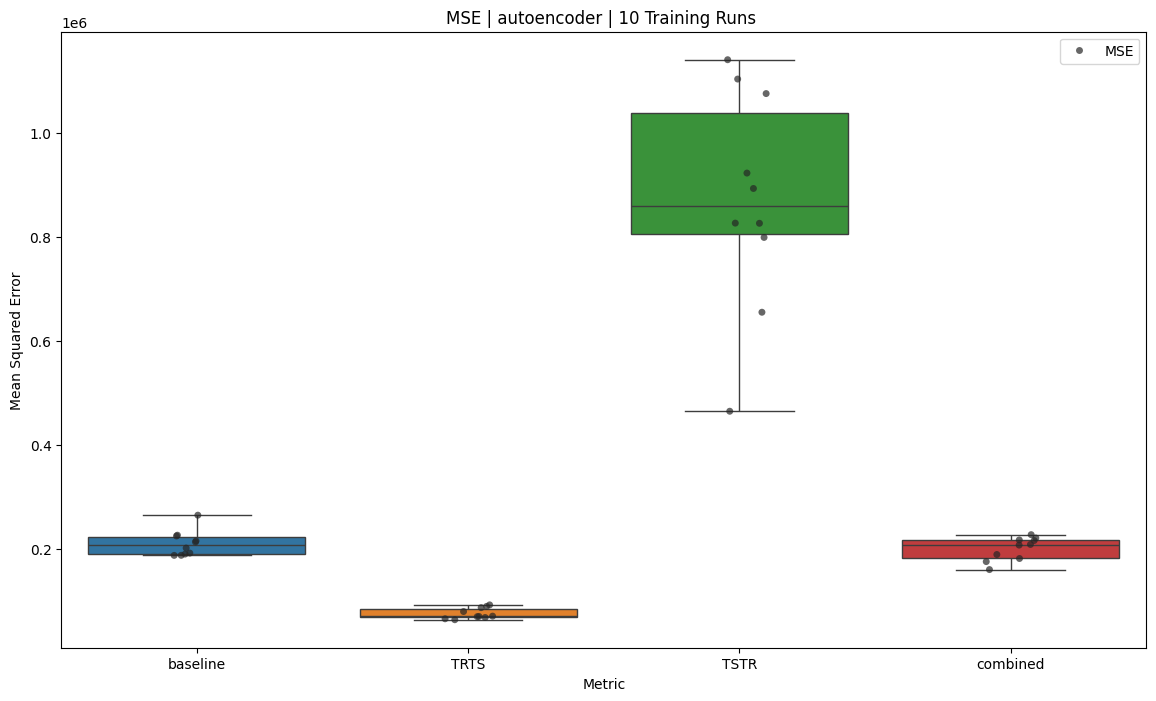

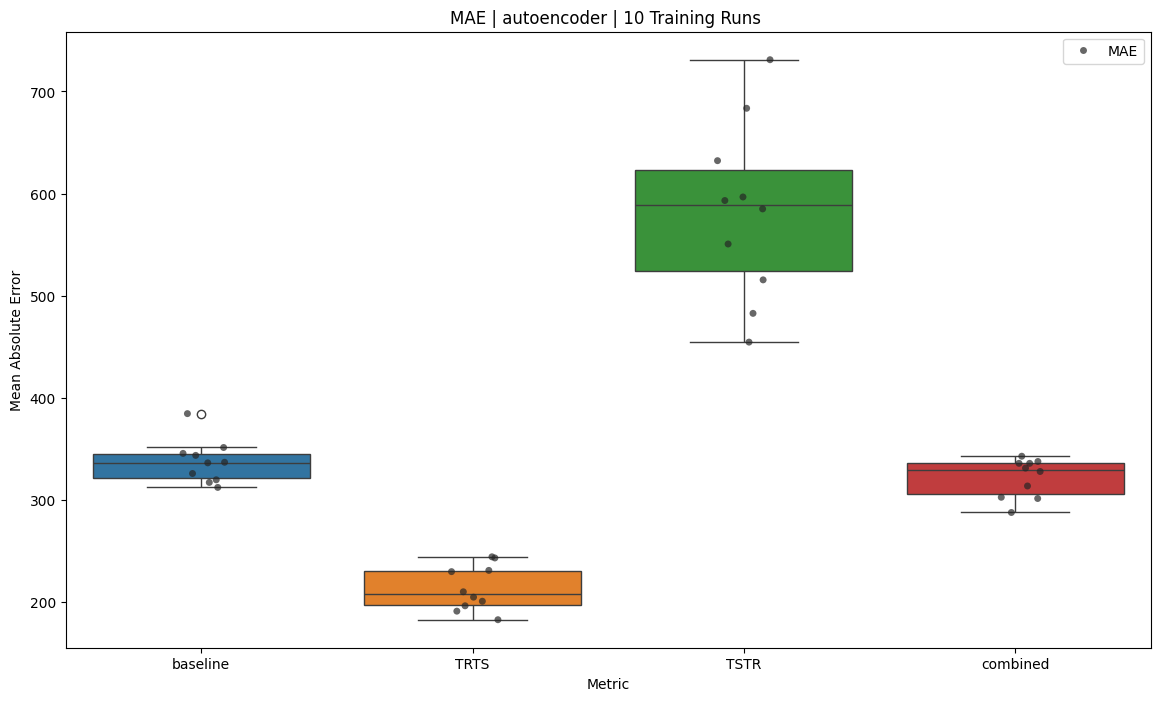

In [10]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [11]:
0.2*1e06

200000.0